In [4]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

In [66]:
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.7 * fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Rate equations

In [40]:
def type_Ia_rate(t):
    return RIa(t.to(u.Myr).value) / u.Msun / u.Myr

@np.vectorize
def RIa(tMyr):
    if tMyr > 37.53:
        rate = 5.3e-8 + 1.6e-5 * np.exp(-((tMyr - 50) / 10)**2 / 2)
    else:
        rate = 0.0
    return rate

In [43]:
def type_II_rate(t):
    return RII(t.to(u.Myr).value) / u.Msun / u.Myr

@np.vectorize
def RII(tMyr):
    if tMyr < 3.401:
        rate = 0.0
    elif tMyr < 10.37:
        rate = 5.408e-4
    elif tMyr < 37.53:
        rate = 2.516e-4
    else:
        rate = 0.0
    return rate

In [92]:
ZSUN = 0.02

def mass_loss_rate(t, Z, m):
    return MdotOBAGB(t.to(u.Myr).value, Z) / u.Gyr * m

@np.vectorize
def MdotOBAGB(tMyr, Z):
    if tMyr < 1:
        fw = 4.763 * (0.01 + Z / ZSUN)
    elif tMyr < 3.5:
        fw = 4.763 * (0.01 + Z / ZSUN) * tMyr**(1.45 + 0.8 * np.log(Z / ZSUN))
    elif tMyr < 100:
        fw = 29.4 * (tMyr / 3.5)**(-3.25) + 0.0042
    else:
        fw = 0.42 * ((tMyr / 1000)**(-1.1) / (19.81 - np.log(tMyr)))
    return fw

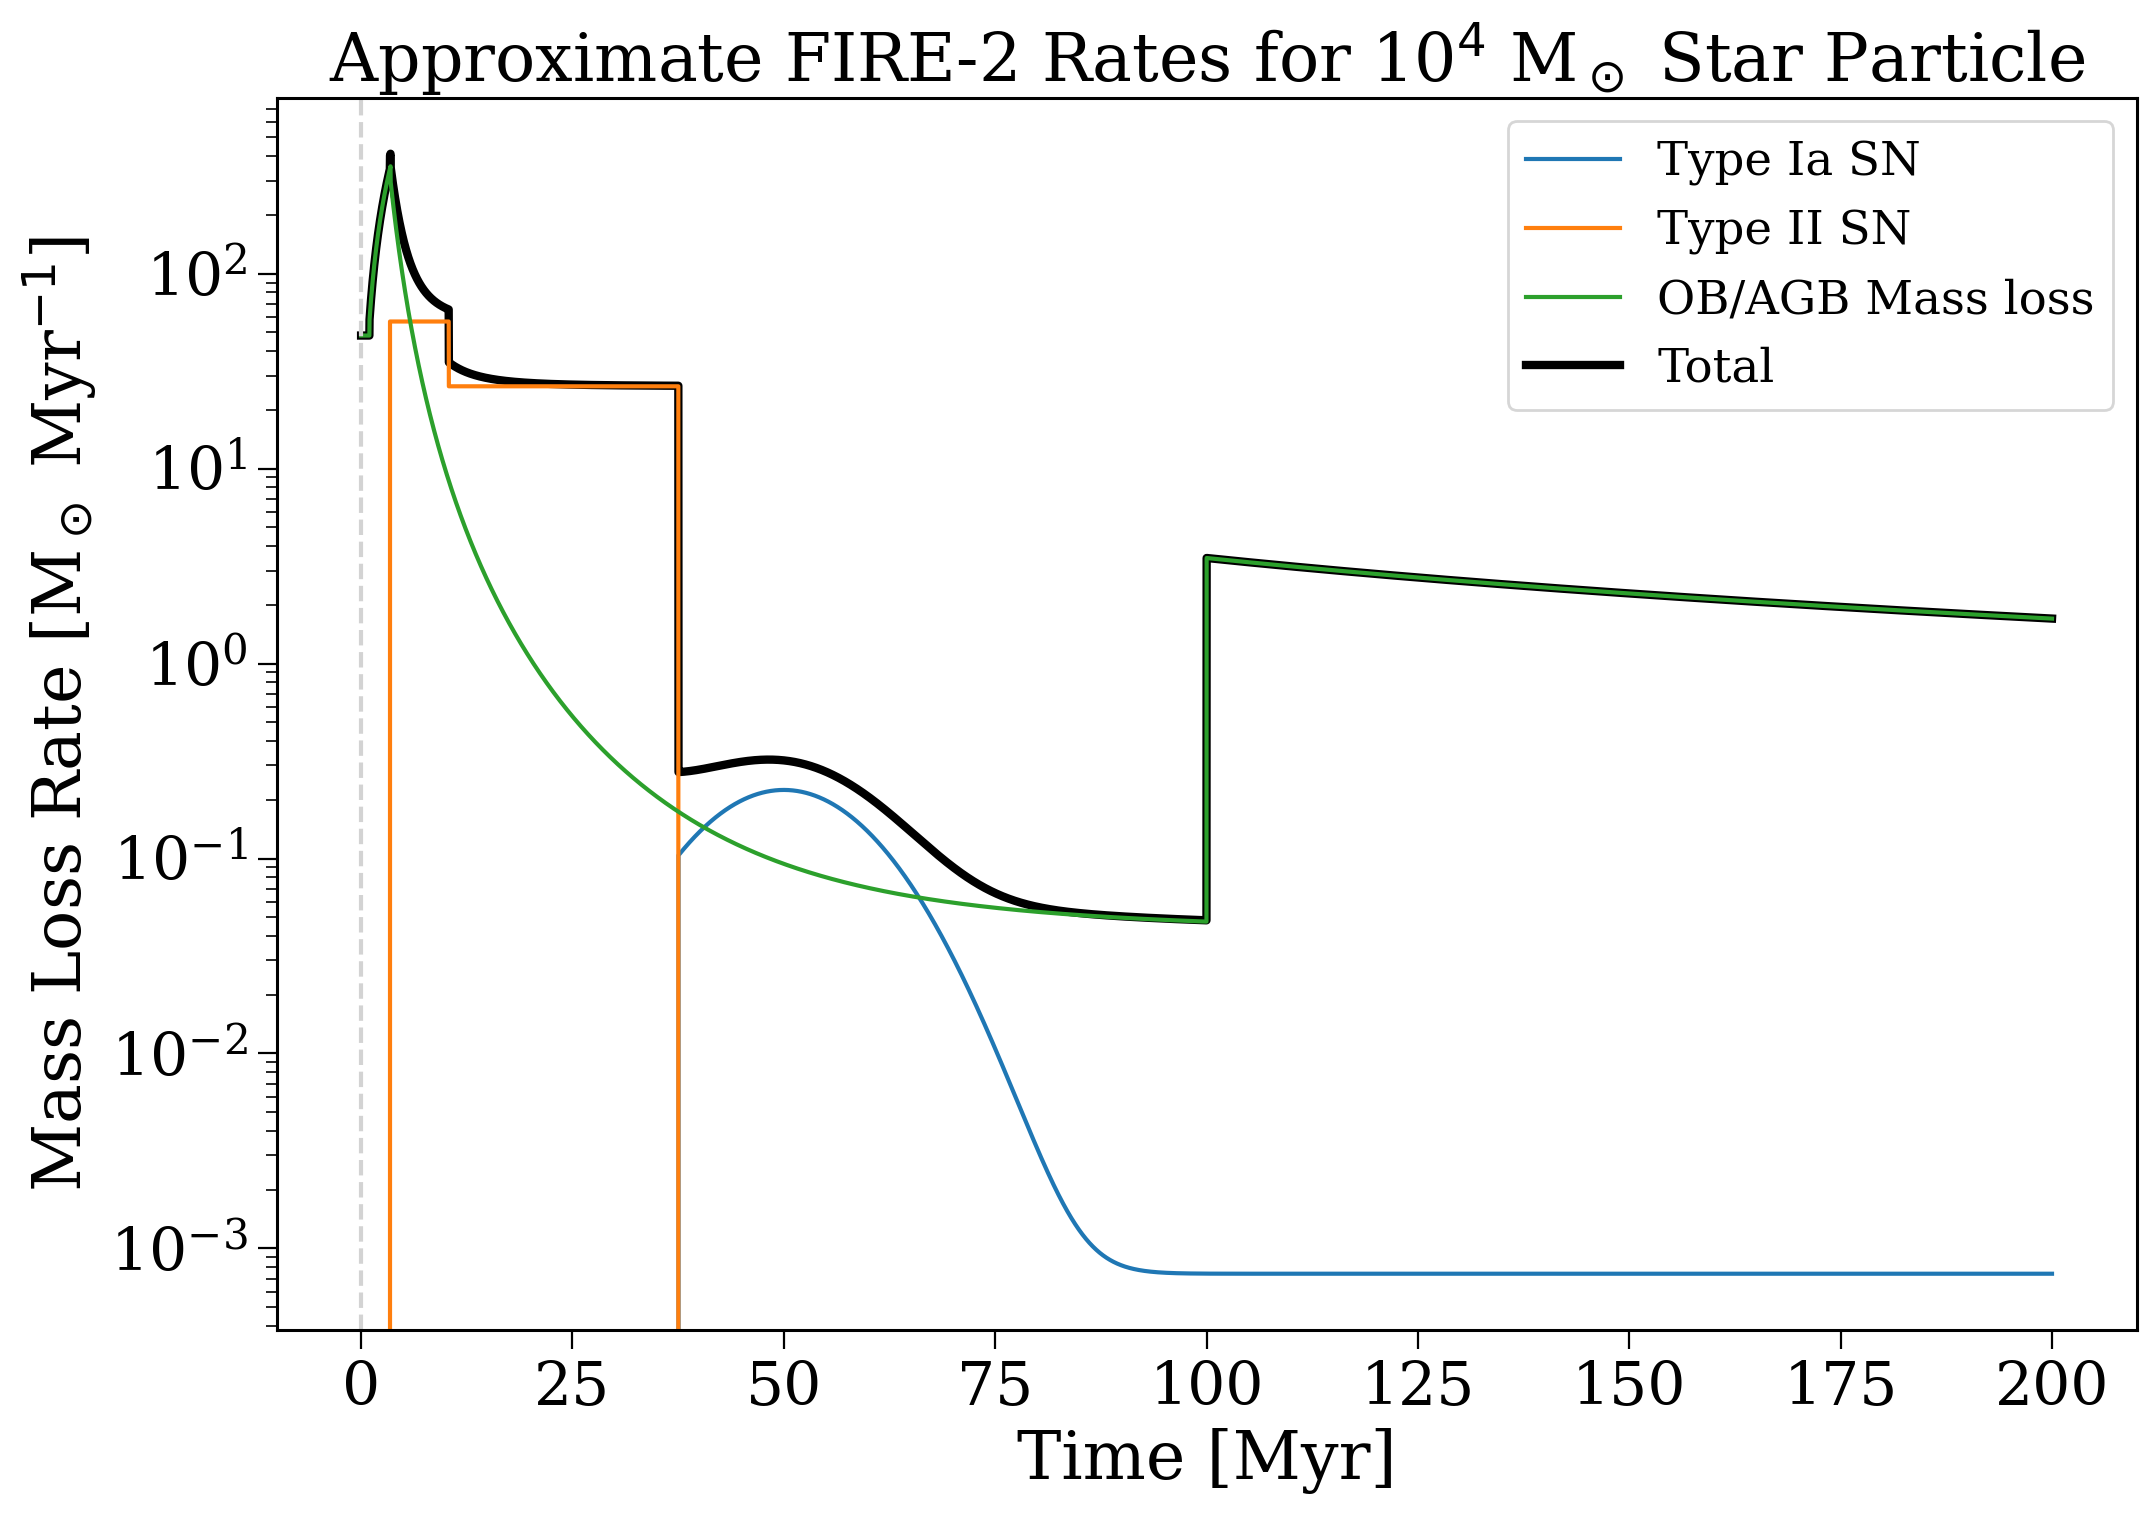

In [152]:
t = np.linspace(0, 200, 10000) * u.Myr

fig, ax = plt.subplots()

M = 10000 * u.Msun

for rate, label in zip([type_Ia_rate(t) * M * 1.4 * u.Msun, type_II_rate(t) * M * 10.5 * u.Msun, mass_loss_rate(t, 0.02, M)],
                       ["Type Ia SN", "Type II SN", "OB/AGB Mass loss"]):
    ax.plot(t, rate.to(u.Msun / u.Myr), label=label)
ax.plot(t, (type_Ia_rate(t) * M * 1.4 * u.Msun + type_II_rate(t) * M * 10.5 * u.Msun + mass_loss_rate(t, 0.02, M)).to(u.Msun / u.Myr),
        label="Total", linewidth=3, color="black", zorder=-1)

ax.set_yscale("log")
ax.legend()

ax.axvline(0.0, linestyle="dashed", color="lightgrey")

ax.set_xlabel("Time [Myr]")
ax.set_ylabel("Mass Loss Rate [M$_\odot$ Myr$^{-1}$]")

ax.set_title("Approximate FIRE-2 Rates for 10$^4$ M$_\odot$ Star Particle", fontsize=fs)

plt.show()

# Reverse engineering

In [145]:
def get_mass_evolution(m_final, t_final, Z):
    t_range = np.flip(np.linspace(0, t_final.to(u.Myr).value, 1000) * u.Myr)
    dt = t_range[1:] - t_range[:-1]
    dt = np.append(dt, dt[0])

    mass_range = np.empty(len(t_range)) * u.Msun

    mass_range[0] = m_final
    for i in range(1, len(t_range)):
        mass_range[i] = mass_range[i - 1] - (type_Ia_rate(t_range[i]) * mass_range[i - 1] * 1.4 * u.Msun
                   + type_II_rate(t_range[i]) * mass_range[i - 1] * 10.5 * u.Msun
                   + mass_loss_rate(t_range[i], Z, mass_range[i - 1])) * dt[i]
    return t_range, mass_range

In [140]:
def get_original_mass(m_final, t_final, Z):
    t_range = np.flip(np.linspace(0, t_final.to(u.Myr).value, 1000) * u.Myr)
    dt = t_range[1:] - t_range[:-1]
    dt = np.append(dt, dt[0])

    m_curr = np.copy(m_final)
    for i in range(len(t_range)):
        m_curr -= (type_Ia_rate(t_range[i]) * m_curr * 1.4 * u.Msun
                   + type_II_rate(t_range[i]) * m_curr * 10.5 * u.Msun
                   + mass_loss_rate(t_range[i], Z, m_curr)) * dt[i]
    return m_curr

In [149]:
%%timeit
get_original_mass(15000 * u.Msun, t_final=80 * u.Myr, Z=0.02)

307 ms ± 1.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


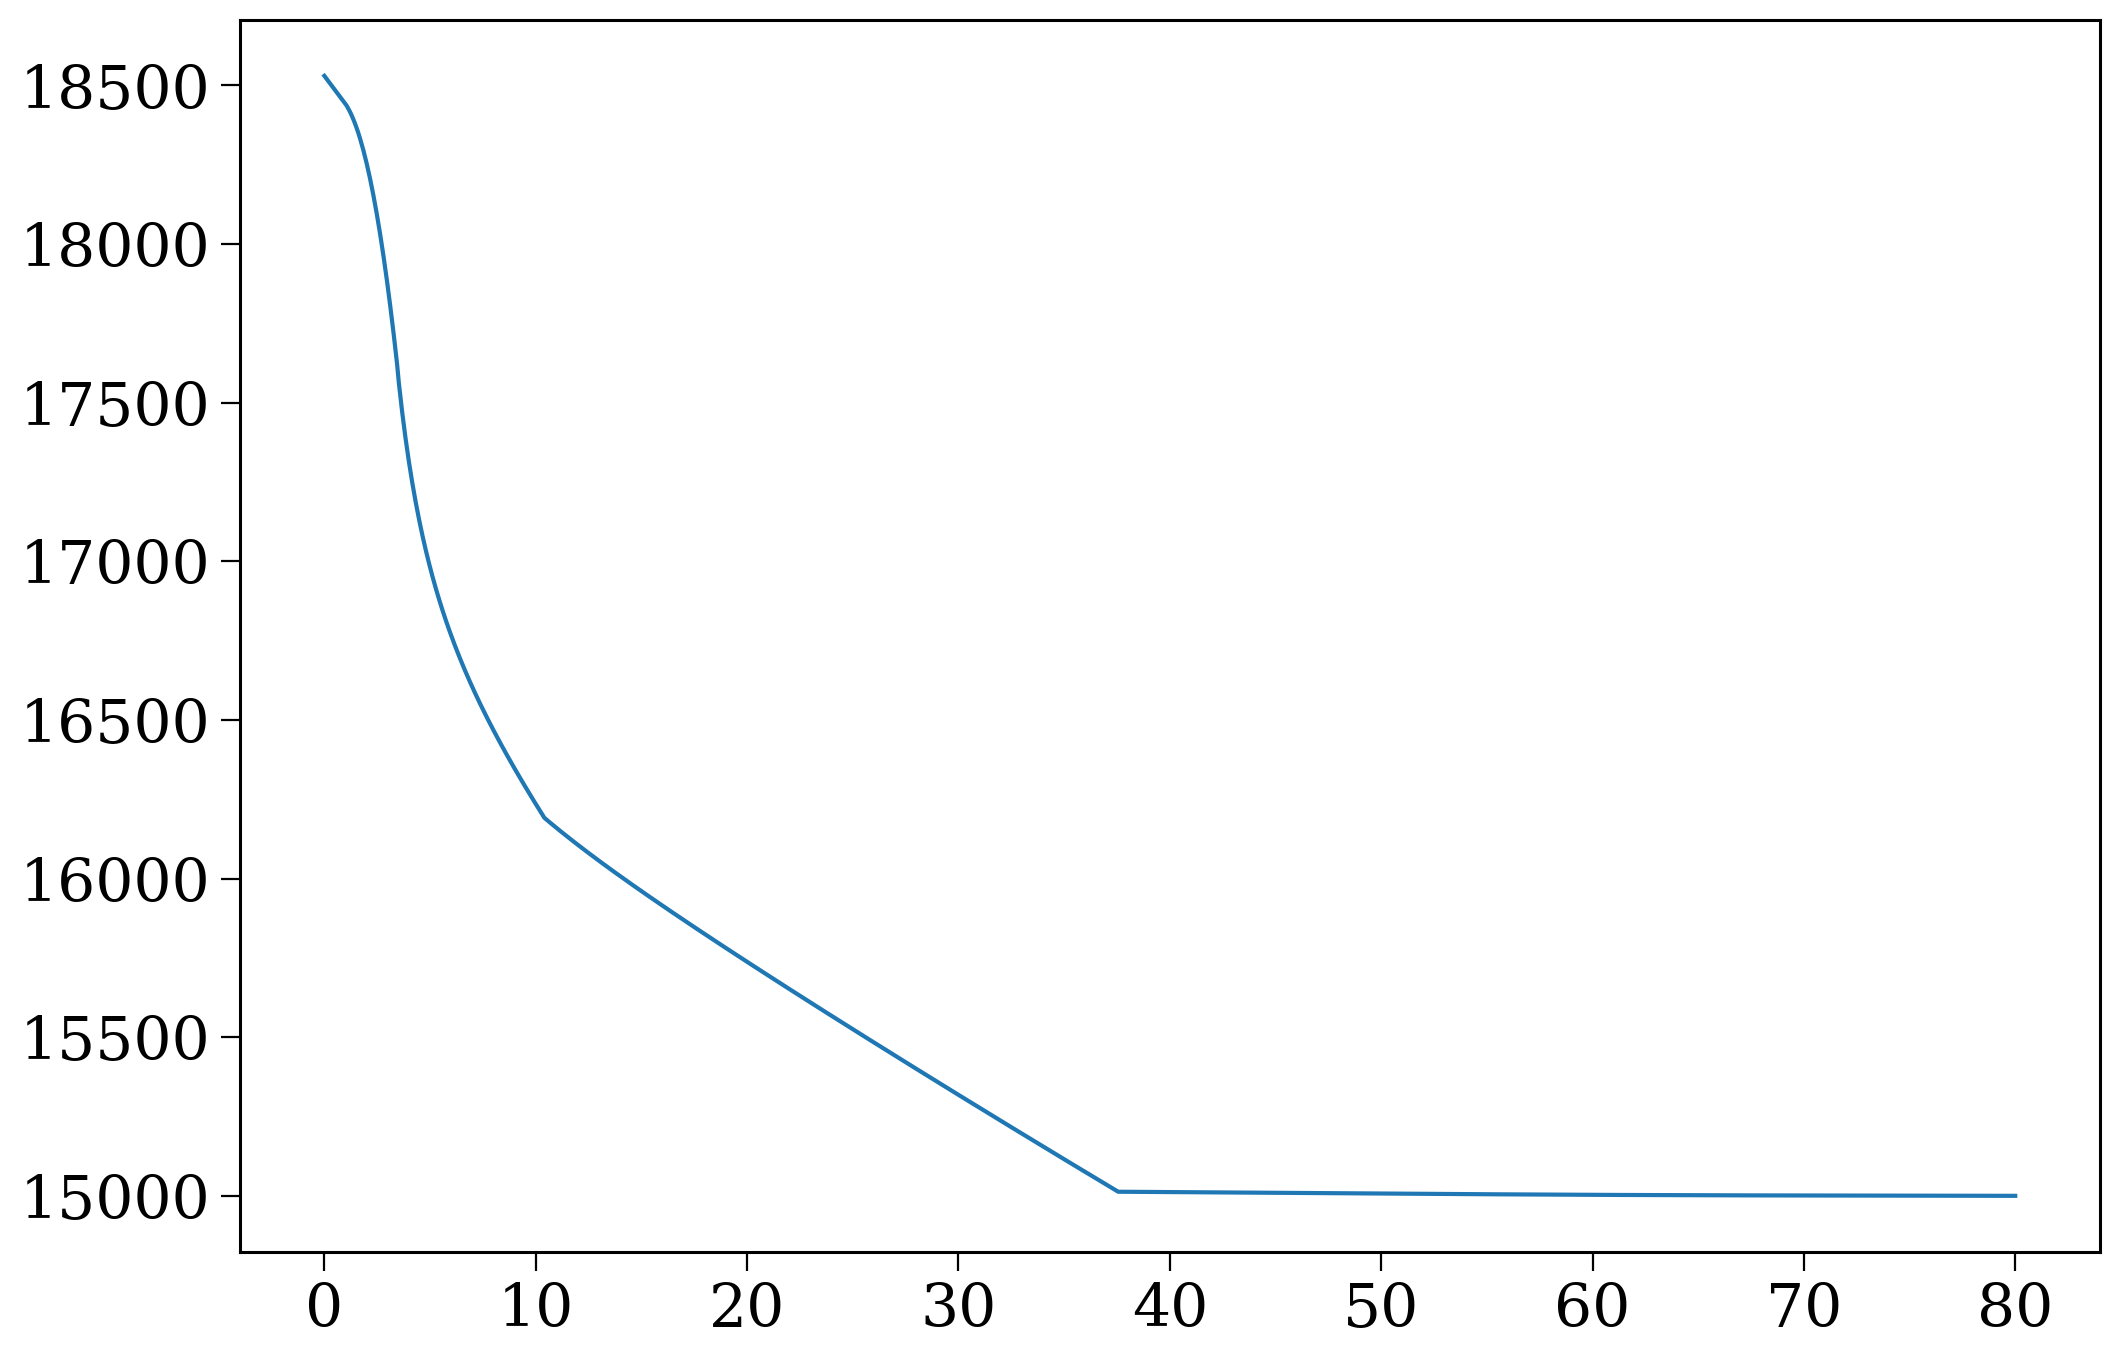

In [147]:
plt.plot(*get_mass_evolution(15000 * u.Msun, t_final=80 * u.Myr, Z=0.02))